<a href="https://colab.research.google.com/github/amanzoni1/Fine_Tuning/blob/main/SFT_Gemma_7B_Instruct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Tuning Gemma-7B-Instruct for Financial Sentiment Classification

## 🎯 Project Overview

In this comprehensive Colab project, we'll demonstrate **memory-efficient fine-tuning** of a large language model using modern techniques. We'll transform **Gemma-7B-Instruct** from a general-purpose assistant into a specialized financial sentiment classifier through parameter-efficient training.

## 🔧 Technical Stack
- **Base Model**: Gemma-7B-Instruct (7B parameters)
- **Fine-tuning Method**: Supervised Fine-Tuning (SFT) with LoRA adapters
- **Memory Optimization**: 4-bit quantization via bitsandbytes
- **Framework**: Transformers + PEFT + TRL


## 💡 Why Fine-Tune Instead of Zero-Shot?

Large language models like Gemma can do sentiment analysis out-of-the-box, but fine-tuning gives you:

1. **Update + Learn New Knowledge**  
   Inject domain-specific financial terminology and market context that general models might miss—for example:  
   - *“Fed hawkish stance”* → Recognize central bank policy implications  
   - *“Earnings beat by 15%”* → Grasp magnitude significance

2. **Customize Behavior**  
   Enforce consistent, structured outputs:  
   - Turn verbose explanations into clean labels  
   - Standardize optional fields (e.g. confidence scores)  

3. **Optimize for Your Task**  
   Improve accuracy on subtle, finance-specific sentiment cues:  
   - Distinguish market-moving news vs. routine reports  
   - Handle jargon, numbers, and percentages robustly

## 📊 Generative Classification

Instead of traditional classification heads, we frame sentiment analysis as a **generative task**:

```
Input Prompt:
"Analyze the sentiment of this financial headline: 'Apple reports record Q3 revenue, beats analyst expectations by 12%'
Sentiment:"

Expected Output:
{
  "sentiment": "POSITIVE",
  "confidence": 0.87
}
```

This approach leverages the model's natural language generation capabilities while maintaining structure.


# Load & Inspect Dataset

Install and import everything we’ll need for this section, and configure our plotting style.

In [1]:
!pip install --quiet seaborn matplotlib
!pip install -U datasets

In [83]:
from datasets import load_dataset, load_dataset_builder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [103]:
# Configure plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("pastel")

In [78]:
# Preview dataset metadata
ds_builder = load_dataset_builder("financial_phrasebank", "sentences_75agree")
print("Description:\n", ds_builder.info.description[:500], "...\n")
print("Features:", ds_builder.info.features)

Description:
 The key arguments for the low utilization of statistical techniques in
financial sentiment analysis have been the difficulty of implementation for
practical applications and the lack of high quality training data for building
such models. Especially in the case of finance and economic texts, annotated
collections are a scarce resource and many are reserved for proprietary use
only. To resolve the missing training data problem, we present a collection of
∼ 5000 sentences to establish human-annota ...

Features: {'sentence': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}


In [79]:
# Load the data
raw = load_dataset("financial_phrasebank", "sentences_75agree")
print("\nRaw dataset object:\n", raw)

FinancialPhraseBank-v1.0.zip:   0%|          | 0.00/682k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3453 [00:00<?, ? examples/s]


Raw dataset object:
 DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 3453
    })
})


In [80]:
# Extract the train split
dataset = load_dataset("financial_phrasebank", "sentences_75agree", split="train")

print("\nDataset object:\n", dataset)
print(f"\nUsing 'train' split with {len(dataset)} examples.")


Dataset object:
 Dataset({
    features: ['sentence', 'label'],
    num_rows: 3453
})

Using 'train' split with 3453 examples.


### Sample Sentences

Show 3 example headlines per sentiment class straight from the `Dataset` API.

In [81]:
# get the label names from the ClassLabel feature
label_names = dataset.features["label"].names

for label_id, label_name in enumerate(label_names):
    print(f"\n{label_name.upper()} examples:")
    # filter down to this label, then select the first 3
    examples = (
        dataset
        .filter(lambda ex: ex["label"] == label_id)
        .select(range(3))
    )
    for i, ex in enumerate(examples, start=1):
        print(f"  {i}. {ex['sentence']}")


NEGATIVE examples:


Filter:   0%|          | 0/3453 [00:00<?, ? examples/s]

  1. Jan. 6 -- Ford is struggling in the face of slowing truck and SUV sales and a surfeit of up-to-date , gotta-have cars .
  2. Pharmaceuticals group Orion Corp reported a fall in its third-quarter earnings that were hit by larger expenditures on R&D and marketing .
  3. However , the growth margin slowed down due to the financial crisis .

NEUTRAL examples:


Filter:   0%|          | 0/3453 [00:00<?, ? examples/s]

  1. According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
  2. At the request of Finnish media company Alma Media 's newspapers , research manager Jari Kaivo-oja at the Finland Futures Research Centre at the Turku School of Economics has drawn up a future scenario for Finland 's national economy by using a model developed by the University of Denver .
  3. In Sweden , Gallerix accumulated SEK denominated sales were down 1 % and EUR denominated sales were up 11 % .

POSITIVE examples:


Filter:   0%|          | 0/3453 [00:00<?, ? examples/s]

  1. With the new production plant the company would increase its capacity to meet the expected increase in demand and would improve the use of raw materials and therefore increase the production profitability .
  2. For the last quarter of 2010 , Componenta 's net sales doubled to EUR131m from EUR76m for the same period a year earlier , while it moved to a zero pre-tax profit from a pre-tax loss of EUR7m .
  3. In the third quarter of 2010 , net sales increased by 5.2 % to EUR 205.5 mn , and operating profit by 34.9 % to EUR 23.5 mn .


### Sentiment Distribution

**Compute** counts & percentages, then plot **count** and **percentage**.

Neutral  : 2146 (62.1%)
Positive : 887 (25.7%)
Negative : 420 (12.2%)


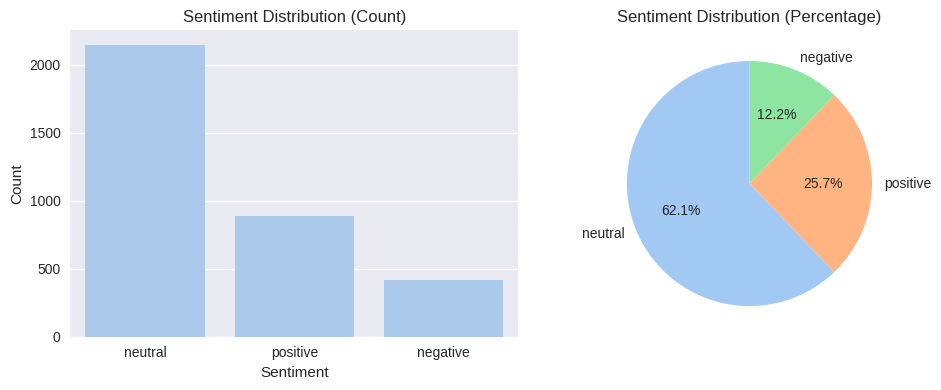

In [82]:
# Build label→count mapping
label_names = dataset.features["label"].names
counts = Counter(label_names[l] for l in dataset["label"])
total = sum(counts.values())

# Print counts and percentages
for name, cnt in counts.items():
    pct = cnt / total * 100
    print(f"{name.capitalize():9s}: {cnt} ({pct:.1f}%)")

# Plot count distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
# Bar chart (Count)
sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=ax1)
ax1.set_title("Sentiment Distribution (Count)")
ax1.set_xlabel("Sentiment")
ax1.set_ylabel("Count")

# Pie chart (Percentage)
ax2.pie(counts.values(), labels=counts.keys(), autopct="%1.1f%%", startangle=90)
ax2.set_title("Sentiment Distribution (Percentage)")

plt.tight_layout()
plt.show()

Overall statistics:
 • Avg characters   : 124.9
 • Avg words        : 22.8
 • Avg word length  : 4.5

By-sentiment averages:
         char_count       word_count       avg_word_length     
               mean   std       mean   std            mean  std
label                                                          
negative      126.4  53.8       24.5  10.1             4.2  0.6
neutral       120.9  56.6       21.5   9.8             4.7  0.7
positive      133.6  56.3       24.9  10.3             4.4  0.7


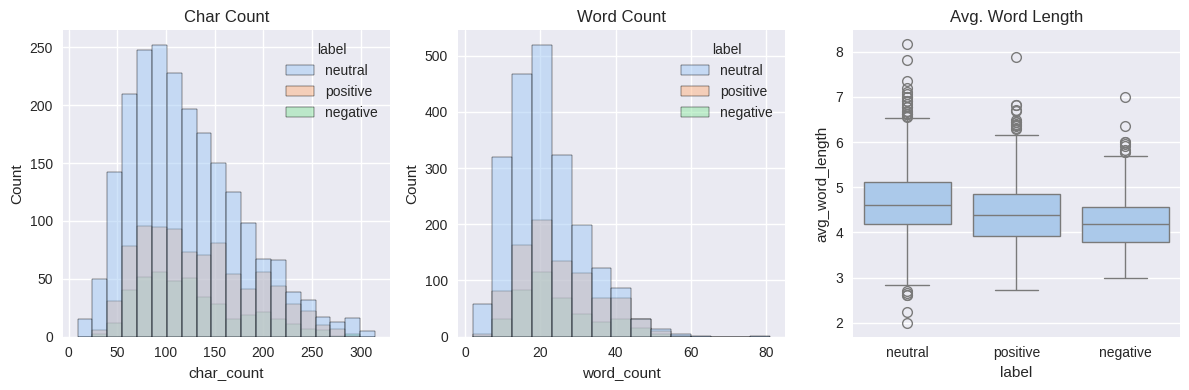

In [88]:
df = pd.DataFrame(dataset)

# Compute metrics
df["char_count"]     = df["sentence"].str.len()
df["word_count"]     = df["sentence"].str.split().str.len()
df["avg_word_length"]= df["sentence"].apply(lambda s: np.mean([len(w) for w in s.split()]))

# Print overall stats
print("Overall statistics:")
print(f" • Avg characters   : {df['char_count'].mean():.1f}")
print(f" • Avg words        : {df['word_count'].mean():.1f}")
print(f" • Avg word length  : {df['avg_word_length'].mean():.1f}")

# Distribution by sentiment
print("\nBy-sentiment averages:")
stats = df.groupby(df["label"].map(lambda i: dataset.features["label"].names[i])) \
           .agg({
             "char_count":     ["mean","std"],
             "word_count":     ["mean","std"],
             "avg_word_length":["mean","std"]
           }).round(1)
print(stats)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
sns.histplot(df, x="char_count",   hue=df["label"].map(lambda i: dataset.features["label"].names[i]),
             kde=False, ax=axes[0], bins=20).set(title="Char Count")
sns.histplot(df, x="word_count",   hue=df["label"].map(lambda i: dataset.features["label"].names[i]),
             kde=False, ax=axes[1], bins=15).set(title="Word Count")
sns.boxplot(x=df["label"].map(lambda i: dataset.features["label"].names[i]),
            y="avg_word_length", data=df, ax=axes[2]).set(title="Avg. Word Length")
plt.tight_layout()
plt.show()

📚 CLEANED VOCABULARY (no numbers, no stopwords)
eur         : 916
company     : 577
profit      : 385
net         : 379
sales       : 377
million     : 366
finnish     : 350
said        : 344
year        : 338
operating   : 258
mln         : 255
quarter     : 237
group       : 237
period      : 236
finland     : 228
share       : 193
business    : 186
oyj         : 168
new         : 166
shares      : 166


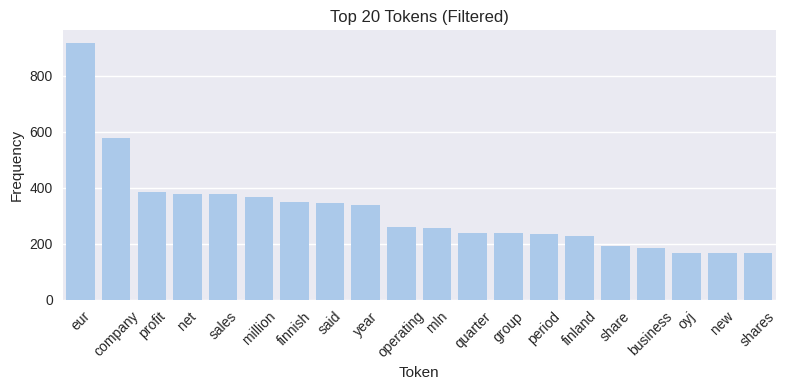

In [99]:
import re
import string
from collections import Counter
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Build stopword set + punctuation
stopwords = set(ENGLISH_STOP_WORDS) | set(string.punctuation)

# Tokenize & filter out stopwords, tokens containing digits, and very short tokens
tokens = []
for sent in df["sentence"].str.lower():
    words = re.findall(r'\b\w+\b', sent)
    for w in words:
        if (
            w not in stopwords           # not a stopword/punctuation
            and not re.search(r'\d', w)  # no digits
            and len(w) > 2               # longer than 2 chars
        ):
            tokens.append(w)

# Get top 20 tokens now
freq = Counter(tokens)
top20 = freq.most_common(20)

print("="*60)
print("📚 CLEANED VOCABULARY (no numbers, no stopwords)")
print("="*60)
for word, count in top20:
    print(f"{word:12s}: {count}")

# Plot
plt.figure(figsize=(8, 4))
sns.barplot(x=[w for w,_ in top20], y=[c for _,c in top20])
plt.title("Top 20 Tokens (Filtered)")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

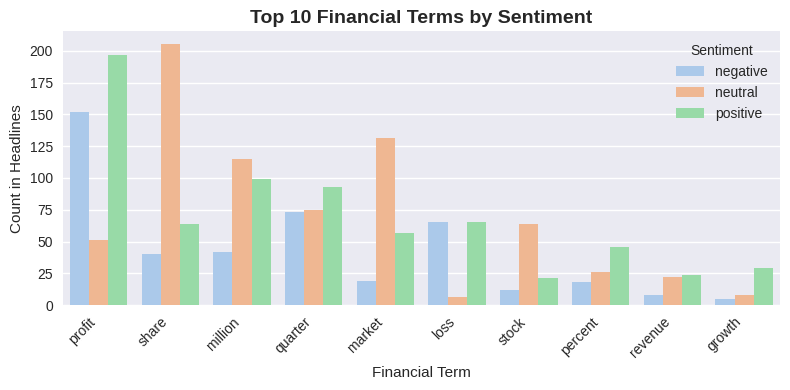

In [104]:
# 1) Define your terms and prepare a list of (term, sentiment, count)
financial_terms = [
    'revenue', 'profit', 'loss', 'earnings', 'growth', 'decline',
    'stock', 'share', 'dividend', 'quarter', 'market',
    'analyst', 'forecast', 'billion', 'million', 'percent',
    'beat', 'miss', 'guidance', 'outlook', 'performance', 'results'
]

records = []
label_names = dataset.features["label"].names

for label_id, label_name in enumerate(label_names):
    # extract all sentences for this sentiment
    sub = df[df["label"] == label_id]["sentence"].str.lower()
    # count each term
    term_counts = {term: sub.str.contains(term, regex=False).sum() for term in financial_terms}
    for term, cnt in term_counts.items():
        records.append({"term": term, "sentiment": label_name, "count": cnt})

# 2) Build a DataFrame and pick top N terms overall
term_df = pd.DataFrame(records)
overall = term_df.groupby("term").sum().sort_values("count", ascending=False).head(10).index.tolist()
plot_df = term_df[term_df["term"].isin(overall)]

# 3) Plot grouped bar chart
plt.figure(figsize=(8, 4))
sns.barplot(
    data=plot_df,
    x="term", y="count", hue="sentiment",
    order=overall
)
plt.title("Top 10 Financial Terms by Sentiment", fontsize=14, fontweight='bold')
plt.xlabel("Financial Term")
plt.ylabel("Count in Headlines")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

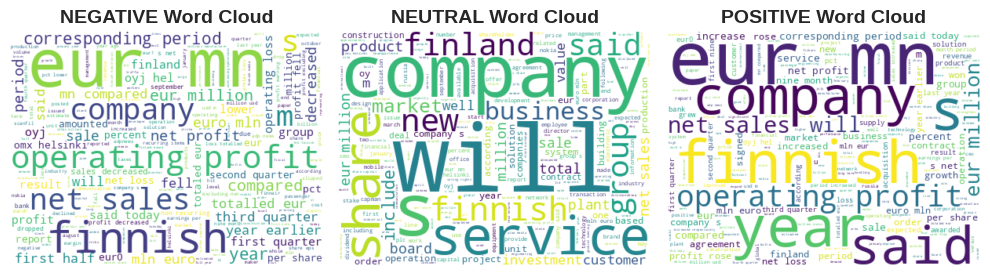

In [105]:
from wordcloud import WordCloud

# Prepare a figure with one subplot per sentiment
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

for i, sentiment in enumerate(label_names):
    # Concatenate all headlines for this sentiment
    text = " ".join(df[df["label"] == i]["sentence"].str.lower())

    # Generate and display the word cloud
    wc = WordCloud(
        width=400, height=300,
        background_color="white",
        colormap="viridis"
    ).generate(text)

    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(f"{sentiment.upper()} Word Cloud", fontsize=14, fontweight="bold")
    axes[i].axis("off")

plt.tight_layout()
plt.show()